In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import time
#import scipy
#import random
import cmath
#import pylops # might not need
import math
#import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.test import compute_gradient
from tensorflow.compat.v1 import assign_sub

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

import autosetup 
from backpropagation import CBP, CBP_decoder, CBP_decoder_v2
from complex_optimizer import Complex_SGD, adaptive_stepsize

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Autoencoder ptygenography

### Loading datasets

In [ ]:
# first draft code from: https://www.tensorflow.org/tutorials/generative/autoencoder
# don't forget to cite the databases

#### MNIST, fashion MNIST, CIFAR10

##### CIFAR10

In [90]:
# CIFAR10
(x_train_cf, cls_train_cf), (x_test_cf, cls_test_cf) = cifar10.load_data()
rtp = 20 # resolution reduction to
lbl = 9 # choice of type: https://www.cs.toronto.edu/~kriz/cifar.html

# change shapes of labels
cls_train_cf_lbl = tf.squeeze(cls_train_cf) == lbl
cls_test_cf_lbl = tf.squeeze(cls_test_cf) == lbl

x_train_gray = x_train_cf.astype('float32') / 255. #normalize the data
x_test_gray = x_test_cf.astype('float32') / 255.

x_train_gray = tf.image.rgb_to_grayscale(x_train_gray)  # shape: (50000, 32, 32, 1)
x_test_gray = tf.image.rgb_to_grayscale(x_test_gray)

x_train_gray = tf.squeeze(x_train_gray) # remove the color component
x_test_gray = tf.squeeze(x_test_gray)

# filter dataset for lbl to rtp x rtp complex set of dataset
#training
x_train_lbl = x_train_gray[cls_train_cf_lbl.numpy()] 
x_train_lbl = tf.cast(x_train_lbl, tf.float32)
x_train_lbl = tf.squeeze(x_train_lbl)

x_train_temp = x_train_lbl[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl_small = x_train_temp[:,:,:,0]

x_train_lbl_cx_small = tf.complex(np.ones((x_train_lbl_small.shape)).astype('float32'), x_train_lbl_small)

print("Size complex lower resolution training set of only selected label: ", x_train_lbl_cx_small.shape)

#testing
x_test_lbl = x_test_gray[cls_test_cf_lbl.numpy()] 
x_test_lbl = tf.cast(x_test_lbl, tf.float32)
#x_test_lbl = x_test_lbl.astype('float32')
x_test_lbl = tf.squeeze(x_test_lbl)

x_test_temp = x_test_lbl[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl_small = x_test_temp[:,:,:,0]

x_test_lbl_cx_small = tf.complex(np.ones((x_test_lbl_small.shape)).astype('float32'), x_test_lbl_small)

print("Size complex lower resolution testing set of only selected label: ", x_test_lbl_cx_small.shape)

Size complex lower resolution training set of only selected label:  (5000, 20, 20)
Size complex lower resolution testing set of only selected label:  (1000, 20, 20)


##### MNIST & FASHION MNIST

In [72]:
# original dataset MNIST
(x_train, cls_train), (x_test, cls_test) = mnist.load_data()
rtp = 10 #resize the pixel
lbl = 3 #label
lbl_2 = 1 # another label

# dataset fashion MNIST
#(x_train, cls_train), (x_test, cls_test) = fashion_mnist.load_data()
#rtp = 20 # fashion is too blurry with 10 x 10
#lbl = 8 # choice of type: https://pravarmahajan.github.io/fashion/

## prep different datasets
x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print("Size training dataset: ", x_train.shape)
print("Size testing dataset: ", x_test.shape)

# dataset of 10 x 10 or 20 x 20 pixels instead of 28 x 28
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_small = x_test_temp[:,:,:,0]

print("Size lower resolution training set: ", x_train_small.shape)
print("Size lower resolution testing set: ", x_test_small.shape)

# dataset of 10 x 10 pixels as complex images
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

print("Size of the complex and lower res training set: ",x_train_cx_small.shape)

# filter dataset for 3's to 10 x 10 complex set of MNIST (label 3 is a dress for fashion MNIST)
#training
x_train_lbl = x_train[np.where(cls_train==lbl),:] 
x_train_lbl = x_train_lbl.astype('float32')
x_train_lbl = tf.squeeze(x_train_lbl)

x_train_temp = x_train_lbl[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl_small = x_train_temp[:,:,:,0]

x_train_lbl_cx_small = tf.complex(np.ones((x_train_lbl_small.shape)).astype('float32'), x_train_lbl_small)

print("Size complex lower resolution training set of only 3's: ", x_train_lbl_cx_small.shape)

#testing
x_test_lbl = x_test[np.where(cls_test==lbl),:] 
x_test_lbl = x_test_lbl.astype('float32')
x_test_lbl = tf.squeeze(x_test_lbl)

x_test_temp = x_test_lbl[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl_small = x_test_temp[:,:,:,0]

x_test_lbl_cx_small = tf.complex(np.ones((x_test_lbl_small.shape)).astype('float32'), x_test_lbl_small)

print("Size complex lower resolution testing set of only 3's: ", x_test_lbl_cx_small.shape)

# filter dataset for SECOND label to 10 x 10 complex set of MNIST (label 3 is a dress for fashion MNIST)
#training
x_train_lbl_2 = x_train[np.where(cls_train==lbl_2),:] 
x_train_lbl_2 = x_train_lbl_2.astype('float32')
x_train_lbl_2 = tf.squeeze(x_train_lbl_2)

x_train_temp = x_train_lbl_2[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [rtp,rtp])
x_train_lbl2_small = x_train_temp[:,:,:,0]

x_train_lbl2_cx_small = tf.complex(np.ones((x_train_lbl2_small.shape)).astype('float32'), x_train_lbl2_small)

print("Size complex lower resolution training set of only 1's: ", x_train_lbl2_cx_small.shape)

#testing
x_test_lbl_2 = x_test[np.where(cls_test==lbl_2),:] 
x_test_lbl_2 = x_test_lbl_2.astype('float32')
x_test_lbl_2 = tf.squeeze(x_test_lbl_2)

x_test_temp = x_test_lbl_2[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [rtp,rtp])
x_test_lbl2_small = x_test_temp[:,:,:,0]

x_test_lbl2_cx_small = tf.complex(np.ones((x_test_lbl2_small.shape)).astype('float32'), x_test_lbl2_small)

print("Size complex lower resolution testing set of only 1's: ", x_test_lbl2_cx_small.shape)

# COMBINED DATASETS OF LBL AND LBL2
cap = x_train_lbl_small.shape[0]
x_train_2digits = tf.complex(x_train_lbl2_small[:cap], x_train_lbl_small)

cap_test = x_test_lbl_small.shape[0]
x_test_2digits = tf.complex(x_test_lbl2_small[:cap_test], x_test_lbl_small)

Size training dataset:  (60000, 28, 28)
Size testing dataset:  (10000, 28, 28)
Size lower resolution training set:  (60000, 10, 10)
Size lower resolution testing set:  (10000, 10, 10)
Size of the complex and lower res training set:  (60000, 10, 10)
Size complex lower resolution training set of only 3's:  (6131, 10, 10)
Size complex lower resolution testing set of only 3's:  (1010, 10, 10)
Size complex lower resolution training set of only 1's:  (6742, 10, 10)
Size complex lower resolution testing set of only 1's:  (1135, 10, 10)


In [190]:
## export
export_train = x_train_lbl_cx_small.numpy()
export_test = x_test_lbl_cx_small.numpy()

np.save('CIFAR10_400_only9_train.npy', export_train)
np.save('CIFAR10_400_only9_test.npy', export_test)

In [97]:
## set current dataset
dataset = x_train_lbl_cx_small.numpy()
datatest = x_test_lbl_cx_small.numpy()
dataset_size = dataset.shape[0]
nx = dataset.shape[1]
n = int(nx**2)

print("Shape current dataset using: ", dataset.shape)
print("Length of side: ", nx)

#num_zeros = np.sum(dataset[0] <= 0.1)
#print(num_zeros)

Shape current dataset using:  (6131, 10, 10)
Length of side:  10


In [ ]:
# load MNIST dataset from ptygenography instead
X_pty = np.load('MNIST_64_only3.npy')
n = X_pty.shape[1]
nx = int(np.sqrt(n))
print(X_pty.shape)

X_tf = tf.convert_to_tensor(X_pty, dtype=tf.complex64)
print(type(X_tf))
print(X_tf.shape)

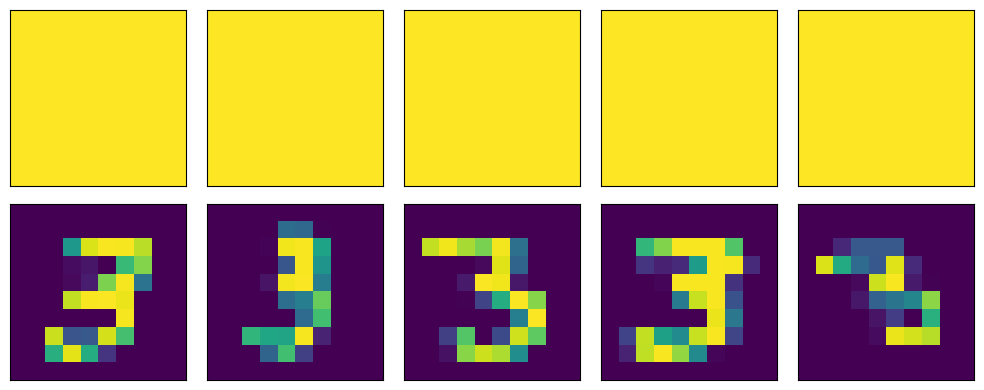

In [98]:
# show the data
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4)) #plt.subplots(2, ns, gridspec_kw={'hspace': 0.005}) 

for i in range(ns):
    x = dataset[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout(h_pad=0.5)

#plt.subplots_adjust(hspace=0.01, wspace=0.1)
fig.subplots_adjust(hspace=0.1)

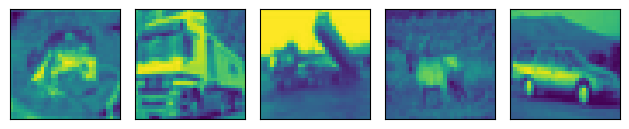

In [108]:
# representation training dataset (real case)
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = dataset[i]
    ax[i].imshow(x.reshape((nx,nx)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

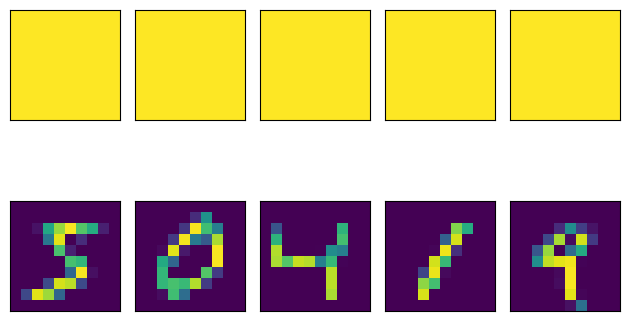

In [4]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = x_train_cx_small[i]
    ax[0,i].imshow(np.real(x).reshape((10,10)),clim=[0,1], cmap= 'viridis')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((10,10)),clim=[0,1], cmap='viridis')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()


### Training loop

In [99]:
## parameters relevant to training
EPOCHS = 100
dataset_size = dataset.shape[0]
reshape_dataset = tf.reshape(dataset, (dataset_size,-1))
sample_shape = reshape_dataset.shape[-1] # data dimension
n = sample_shape # used later
nx = int(np.sqrt(sample_shape)) # one side of the 2D image
midlayer_dim = 50 # for MNIST, use 50, 10 - for CIFAR10, fashion, use 200, 40
latent_dim = 10 # reduction of data 

print("Number of epochs: ", EPOCHS)
print("Dataset size: ", dataset_size)
print("Dimension of one sample: ", sample_shape)
print("Dimension of the middle layer", midlayer_dim)
print("Latent dimension: ", latent_dim)
print("Entire dimensions reshaped dataset: ", reshape_dataset.shape)

Number of epochs:  100
Dataset size:  6131
Dimension of one sample:  100
Dimension of the middle layer 50
Latent dimension:  10
Entire dimensions reshaped dataset:  (6131, 100)


In [76]:
# wrapper for training - only run when training
@tf.function
def train_step(x, alpha, encoder, decoder, optimizer):
    y = decoder(encoder(x))
    loss_value = autosetup.loss_MSE(y, x)
    grads_and_vars = CBP(x, y, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_modrelu)
    new_alpha = adaptive_stepsize(x, y, alpha, encoder, decoder, autosetup.loss_MSE, grads_and_vars)
    _ = optimizer.apply_gradients(grads_and_vars, alpha = alpha)
    return loss_value, new_alpha

In [77]:
# ref: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch
# only run when training a new decoder

train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

encoder = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
decoder = autosetup.ComplexDecoder([midlayer_dim, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = decoder(encoder(dummy))

print(type(train_dataset))

optimizer = Complex_SGD()
alpha = 1e-4 # initial value

for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    for x in train_dataset:
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1 # this is a bit ugly
        epoch_loss += loss.numpy()

        if count % (int(dataset_size/10)) == 0:
            print(
                "Training loss (for one sample) at sample %d: %.4f"
                % (count, float(loss))
            )

    avg_loss = epoch_loss/(dataset_size)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f}") 
    print("Time taken: %.2fs" % (time.time() - start_time))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>

Start of epoch 1
Training loss (for one sample) at sample 613: 22.0139
Training loss (for one sample) at sample 1226: 10.9620
Training loss (for one sample) at sample 1839: 4.9821
Training loss (for one sample) at sample 2452: 5.9561
Training loss (for one sample) at sample 3065: 6.1777
Training loss (for one sample) at sample 3678: 4.0820
Training loss (for one sample) at sample 4291: 3.0130
Training loss (for one sample) at sample 4904: 3.8315
Training loss (for one sample) at sample 5517: 3.8103
Training loss (for one sample) at sample 6130: 4.1431
Epoch 1 | Loss: 8.54780
Time taken: 12.66s

Start of epoch 2
Training loss (for one sample) at sample 613: 13.5610
Training loss (for one sample) at sample 1226: 8.3470
Training loss (for one sample) at sample 1839: 5.7780
Training loss (for one sample) at sample 2452: 6.1775
Training loss (for one sample) at sample 3065: 3.3445
Training loss (for one sample) at sample 3678: 3.3

In [17]:
## only run if continuing with training 
MORE_EPOCHS = 50

# below not necessary if continuing immediately
train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

optimizer = Complex_SGD()
alpha = 1e-4 # initial value

for epoch in range(EPOCHS, EPOCHS + MORE_EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    for x in train_dataset:
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1 # this is a bit ugly
        epoch_loss += loss.numpy()

        if count % (int(dataset_size/10)) == 0:
            print(
                "Training loss (for one sample) at sample %d: %.4f"
                % (count, float(loss))
            )

    avg_loss = epoch_loss/(dataset_size)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f}") 
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 51
Training loss (for one sample) at sample 613: 0.3001
Training loss (for one sample) at sample 1226: 1.3797
Training loss (for one sample) at sample 1839: 1.8747
Training loss (for one sample) at sample 2452: 0.9658
Training loss (for one sample) at sample 3065: 0.6428
Training loss (for one sample) at sample 3678: 1.4069
Training loss (for one sample) at sample 4291: 0.2860
Training loss (for one sample) at sample 4904: 0.5642
Training loss (for one sample) at sample 5517: 0.5025
Training loss (for one sample) at sample 6130: 0.5330
Epoch 51 | Loss: 1.00433
Time taken: 12.79s

Start of epoch 52
Training loss (for one sample) at sample 613: 4.2544
Training loss (for one sample) at sample 1226: 0.7502
Training loss (for one sample) at sample 1839: 0.7713
Training loss (for one sample) at sample 2452: 0.6940
Training loss (for one sample) at sample 3065: 0.5836
Training loss (for one sample) at sample 3678: 0.4926
Training loss (for one sample) at sample 4291: 1.7860
Tr

#### Save random weights pre-training

In [111]:
untrained_encoder = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
untrained_decoder = autosetup.ComplexDecoder([midlayer_dim, sample_shape])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = untrained_decoder(untrained_encoder(dummy))

#### Weights saving

In [78]:
## save the encoder weights (not needed for least squares but helpful in generating examples)
wrap_encoder = autosetup.EncoderSave(encoder)
_ = wrap_encoder(tf.zeros((1, sample_shape), dtype = tf.complex64))

wrap_encoder.save_weights("encoder_100epochs_Xtrain2digits_k10_grad2.weights.h5")

In [79]:
## save the decoder weights
wrap_decoder = autosetup.DecoderSave(decoder)
_ = wrap_decoder(tf.zeros((1, latent_dim), dtype = tf.complex64))

wrap_decoder.save_weights("decoder_100epochs_Xtrain2digits_k10_grad2.weights.h5")

In [100]:
## load the encoder weights
encoder_from_load = autosetup.ComplexEncoder([midlayer_dim, latent_dim])
encoder_model_from_load = autosetup.EncoderSave(encoder_from_load)

## load the decoder weights
decoder_from_load = autosetup.ComplexDecoder([midlayer_dim, sample_shape])
model_from_load = autosetup.DecoderSave(decoder_from_load)

# build
dummy_enc = tf.zeros((1, sample_shape), dtype = tf.complex64)
_ = encoder_from_load(dummy_enc)
_ = encoder_model_from_load(dummy_enc)

dummy_dec = tf.zeros((1, latent_dim), dtype = tf.complex64)
_ = decoder_from_load(dummy_dec)
_ = model_from_load(tf.zeros((1, latent_dim), dtype = tf.complex64))

# load
#model_from_load.load_weights("saved_decoder_test.weights.h5")
model_from_load.load_weights("decoder_100epochs_X3train_k10_grad2.weights.h5")
encoder_model_from_load.load_weights("encoder_100epochs_X3train_k10_grad2.weights.h5")

In [ ]:
## test if the loaded decoder works properly
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
print(type(x_testing))
y = encoder(x_testing)

# if zeros are returned, test succesfull
#print(decoder(y) - model_from_load.decoder(y))

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[1.0560035 -7.74386898e-02j 1.0573239 +8.20555985e-02j
  1.1151439 -9.14341062e-02j 1.0566394 -3.52024026e-02j
  0.93093467-7.01772124e-02j 0.98010314-1.08131403e-02j
  1.0116947 -6.06522523e-02j 1.0721003 +2.21436489e-02j
  0.9977986 +7.54325837e-02j 1.1252183 -9.12407115e-02j
  0.98584217+7.65499771e-02j 1.1194189 -3.10081970e-02j
  1.0479074 +8.06405470e-02j 1.0364313 -1.06292199e-02j
  0.9330173 +1.00438990e-01j 1.053675  +2.20988348e-01j
  1.0738726 +2.39383459e-01j 1.0857968 +4.43139449e-02j
  1.03635   -7.87219480e-02j 0.9503862 -4.71685864e-02j
  0.9079056 -1.49019165e-02j 0.8564091 -3.92761752e-02j
  0.9362015 +5.44368252e-02j 0.9575463 +1.76161274e-01j
  1.0529252 +5.25073826e-01j 1.0500501 +6.51388526e-01j
  1.0366496 +5.24619102e-01j 1.1171299 +3.76128852e-01j
  0.96216846+6.17846064e-02j 1.0660409 +8.73341635e-02j
  1.0847453 -5.12152584e-03j 1.0241363 +4.79821227e-02j
  0.9760021 +1.58020541e-01j 1

In [101]:
## run if decoder should be loaded from save
encoder = encoder_model_from_load.encoder
decoder = model_from_load.decoder

#### Extracting and wrapping autoencoder function

In [102]:
# compute function generative map
def make_tensor_shape(z):
    #z = z.reshape((1,-1))
    tensor_z = tf.convert_to_tensor(z, dtype=tf.complex64)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.complex64)

# wrapper for decoder to numpy function
def decoderfunc_1D(z, decoder):
    '''
    Converts the autoencoder.decoder function into a generative embedding function

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))    

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image). flatten() ensures shape (n,) and not (1,n)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy().flatten()

# wrapper for Jacobian computation to numpy function
def jac_decoder_1D(z, decoder, type = "normal"):
    '''
    Converts the CBP_decoder computation into a numpy function, outputting the R or R*-derivative of the decoder in z as a numpy array
    NOTE: activation function is hardcoded at this point
    NOTE: CBP_decoder_v2 makes a comparable computation but a slightly different order of partial derivative computation. It seems to give the same result

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))
        type:           str, either "normal" or "conj", indicating the R or the R*-derivative
    '''
    dG_dz, dG_dzstar = CBP_decoder(tf.reshape(make_tensor(z), [1,-1]), decoder, autosetup.Jac_modrelu)
    if type == "normal":
        return dG_dz.numpy()
    elif type == "conj":
        return dG_dzstar.numpy()
    else:
        raise ValueError(f"Invalid type '{type}. Must be 'normal' or 'conj'.")        


def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

#### Testing quality of encoder and decoder

tf.Tensor(28.816399, shape=(), dtype=float32)


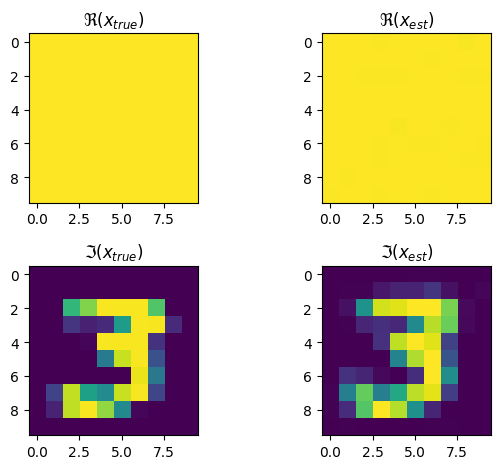

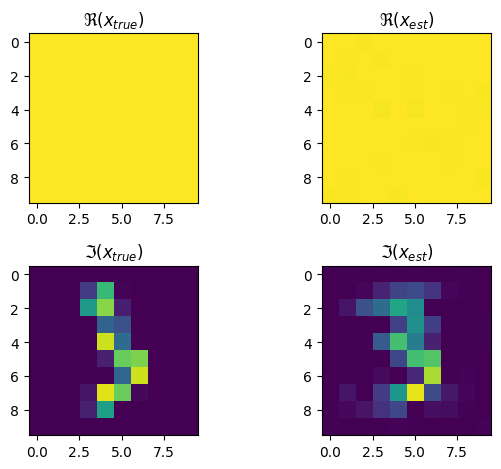

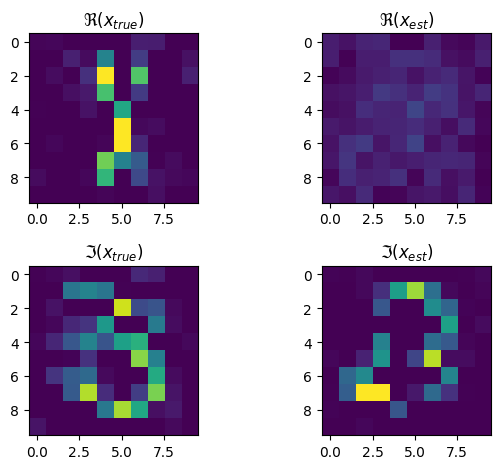

In [103]:
# training and test image
i = 3
train_ex = reshape_dataset[i]
test_ex = datatest[i]
test_encoder = encoder
test_decoder = decoder

encoded_ex_train = test_encoder(make_tensor_shape(train_ex))
decoded_ex_train = test_decoder(encoded_ex_train)

encoded_ex_test = test_encoder(make_tensor_shape(test_ex))
decoded_ex_test = test_decoder(encoded_ex_test)

x_train_plot_ex = train_ex.numpy().flatten()
x_train_recon_ex = decoded_ex_train.numpy().flatten()

x_test_plot_ex = test_ex.flatten()
x_test_recon_ex = decoded_ex_test.numpy().flatten()

plot_result(x_train_plot_ex, x_train_recon_ex)
plot_result(x_test_plot_ex, x_test_recon_ex)

# testoutput PCA
# x_pca = np.load('outputPCA.npy')
# x_pca_recon = test_decoder(test_encoder(make_tensor_shape(x_pca)))

# x_pca_plot = x_pca.flatten()
# x_pca_recon_plot = x_pca_recon.numpy().flatten()

# plot_result(x_pca_plot, x_pca_recon_plot)
# print(autosetup.loss_MSE(x_pca_plot, x_pca_recon_plot))

# testoutput decoder
x_decod = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
x_decod_recon = test_decoder(test_encoder(make_tensor_shape(x_decod)))

x_decod_plot = x_decod.flatten()
x_decod_recon_plot = x_decod_recon.numpy().flatten()

plot_result(x_decod_plot, x_decod_recon_plot)
print(autosetup.loss_MSE(x_decod_plot, x_decod_recon_plot))

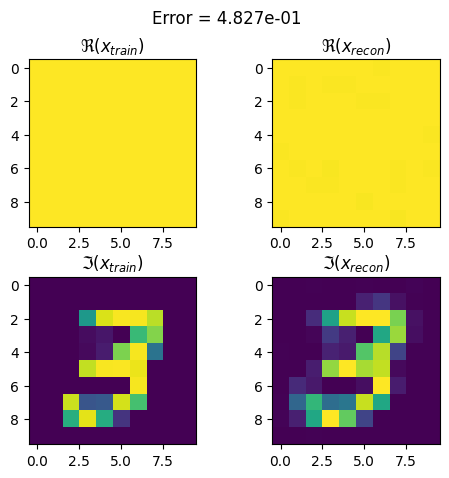

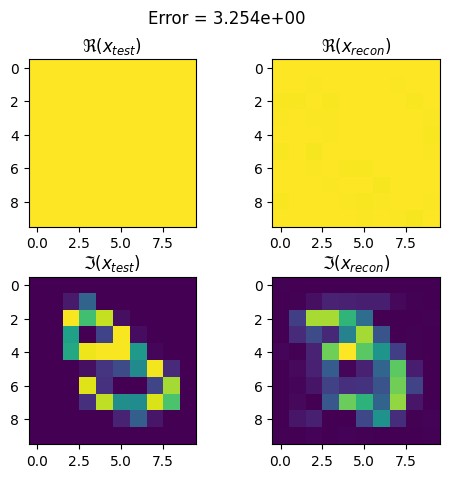

In [104]:
# training and test image, but with custom titles & plots
i = 0
train_ex = reshape_dataset[i]
test_ex = datatest[i]
test_encoder = encoder
test_decoder = decoder

encoded_ex_train = test_encoder(make_tensor_shape(train_ex))
decoded_ex_train = test_decoder(encoded_ex_train)

encoded_ex_test = test_encoder(make_tensor_shape(test_ex))
decoded_ex_test = test_decoder(encoded_ex_test)

x_train_plot_ex = train_ex.numpy().flatten()
x_train_recon_ex = decoded_ex_train.numpy().flatten()

x_test_plot_ex = test_ex.flatten()
x_test_recon_ex = decoded_ex_test.numpy().flatten()

error_train = autosetup.loss_MSE(x_train_recon_ex, x_train_plot_ex)
error_test = autosetup.loss_MSE(x_test_recon_ex, x_test_plot_ex)

# VISUALIZE TRAINING IMAGE
fig, ax = plt.subplots(2,2, figsize=(6,5))

ax[0,0].imshow(np.real(x_train_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{train})$')
ax[1,0].imshow(np.imag(x_train_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{train})$')
ax[0,1].imshow(np.real(x_train_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(x_train_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Error = {error_train:.3e}")
#fig.tight_layout(h_pad=0.5)

#plt.subplots_adjust(hspace=0.01, wspace=0.1)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# VISUALIZE TESTING IMAGE
fig, ax = plt.subplots(2,2, figsize=(6,5))

ax[0,0].imshow(np.real(x_test_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{test})$')
ax[1,0].imshow(np.imag(x_test_plot_ex.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{test})$')
ax[0,1].imshow(np.real(x_test_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(x_test_recon_ex.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Error = {error_test:.3e}")
#fig.tight_layout()

fig.subplots_adjust(hspace=0.3, wspace=0.1)

tf.Tensor(
[[-0.02346991+8.48514289e-02j -0.12723571-7.63047263e-02j
  -0.0646844 +8.26968923e-02j -0.17287354-1.79661587e-01j
   0.06986026-2.46442139e-01j -0.12669507+4.48570810e-02j
  -0.2884927 +1.90316617e-01j -0.22175705-2.04809792e-02j
  -0.        +0.00000000e+00j -0.3730338 -6.55796975e-02j
   0.01086194+2.59517934e-02j -0.04992547+9.72361937e-02j
   0.12722453+8.32616631e-03j -0.0076545 -3.52816254e-01j
  -0.10042952-3.33068430e-01j -0.02084013+9.93115127e-01j
  -0.01337327+3.29604387e-01j -0.11331885-1.17373709e-02j
  -0.08594188-1.55257314e-01j -0.11786738+1.71124563e-01j
  -0.41681123+3.39986920e-01j -0.26895675-2.97461808e-01j
   0.10223398-1.20930803e+00j  0.0390458 +9.52937782e-01j
  -0.17028083+9.27893162e-01j -0.15793042-1.90910709e+00j
  -0.12187886-2.09319830e-01j  0.06169296-2.25414062e+00j
  -0.38626468-1.24885075e-01j  0.01528728-7.04211444e-02j
  -0.2056136 +1.37111902e-01j -0.04747388+3.04059442e-02j
   0.14195147+8.64864111e-01j -0.06625926+1.66949809e-01j
  -

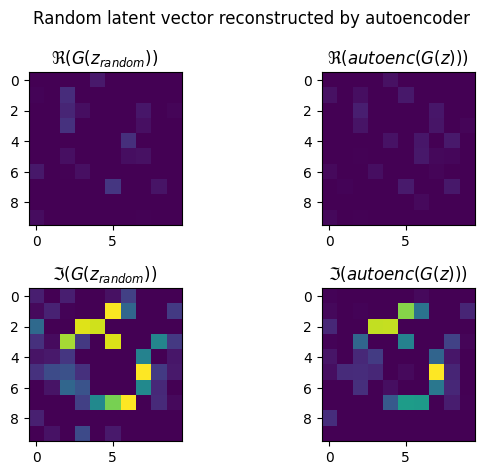

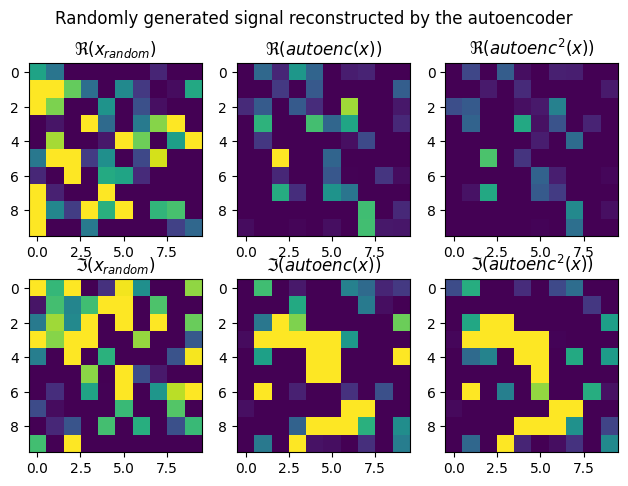

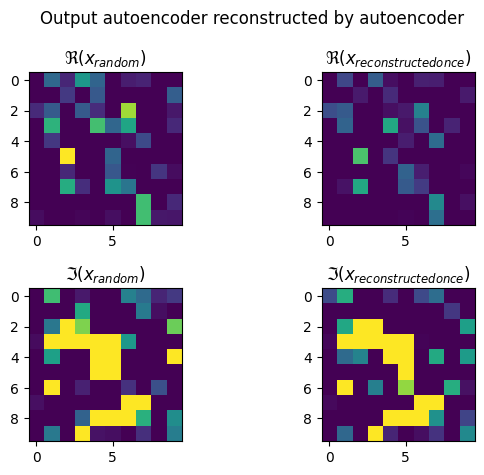

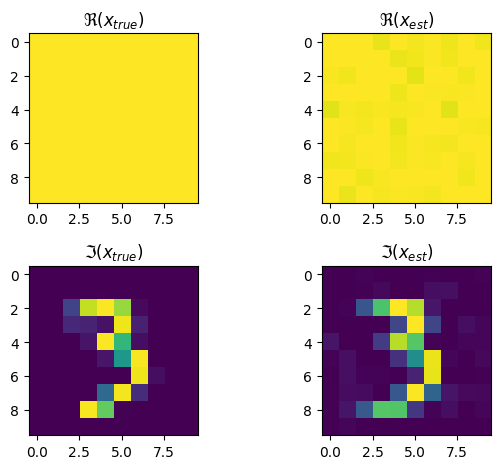

In [ ]:
# random input latent space
z_random = np.random.normal(size=(1,latent_dim)) + 1j*np.random.normal(size=(1,latent_dim))
test_z = decoder(make_tensor(z_random))

z_plot = test_z.numpy().flatten()
z_again_tf = decoder(encoder(test_z))
z_again = z_again_tf.numpy().flatten()

# plot results
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(z_plot.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(G(z_{random}))$')
ax[1,0].imshow(np.imag(z_plot.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(G(z_{random}))$')
ax[0,1].imshow(np.real(z_again.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(autoenc(G(z)))$')
ax[1,1].imshow(np.imag(z_again.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(autoenc(G(z)))$')

fig.suptitle("Random latent space vector through decoder reconstructed by autoencoder")
fig.tight_layout()

# random input original space
x_random = np.random.normal(size=(1,sample_shape)) + 1j*np.random.normal(size=(1,sample_shape))
x_tensor = make_tensor(x_random)
x_random_recon_tf = decoder(encoder(x_tensor)) 
x_random_recon = x_random_recon_tf.numpy().flatten()

x_random = x_random.flatten()

# reconstructed output now through the autoencoder
x_again_tf = decoder(encoder(x_random_recon_tf))
x_again = x_again_tf.numpy().flatten()

# plot results
fig, ax = plt.subplots(2,3)

ax[0,0].imshow(np.real(x_random.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{random})$')
ax[1,0].imshow(np.imag(x_random.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{random})$')
ax[0,1].imshow(np.real(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(autoenc(x))$')
ax[1,1].imshow(np.imag(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(autoenc(x))$')
ax[0,2].imshow(np.real(x_again.reshape((nx,nx))),clim=[0,1])
ax[0,2].set_title(r'$\Re(autoenc^2(x))$')
ax[1,2].imshow(np.imag(x_again.reshape((nx,nx))),clim=[0,1])
ax[1,2].set_title(r'$\Im(autoenc^2(x))$')

fig.suptitle("Randomly generated signal reconstructed by the autoencoder")
fig.tight_layout()


# plot results
fig, ax = plt.subplots(2,2)


ax[0,0].imshow(np.real(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{random})$')
ax[1,0].imshow(np.imag(x_random_recon.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{random})$')
ax[0,1].imshow(np.real(x_again.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{reconstructed once})$')
ax[1,1].imshow(np.imag(x_again.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{reconstructed once})$')

fig.suptitle("Output autoencoder reconstructed by autoencoder")
fig.tight_layout()

# comparing training image with result of decoder
x_testing = tf.reshape(datatest[1], [1,-1])
y = encoder(x_testing)
x_recon = decoder(y)
im_x = tf.math.imag(tf.reshape(x_recon, (1,nx,nx)))

x_plottable = datatest[1].numpy().flatten()
x_plot_recon = x_recon.numpy().flatten()

plot_result(x_plottable, x_plot_recon)

### Integrate with least squares signal optimization

In [105]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, Gstar, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    Dxstar = Gstar.jac(zc)

    #print("Dx norm", np.linalg.norm(Dx @ np.ones_like(zc)))
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    #print("Dy", Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    #gradc  = 2*Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    #gradc  = 2*DF@(yp - y) + (lmbda**2)*(w*w)*zc

    gradc = (Dxstar).T@(Dy.T@np.conj(yp - y)) + Dx.H@(Dy.H@(yp - y))

    #gradc = jac_decoder_1D(zc, decoder,type="conj").T@np.conj(xc - xc_obs) + np.conj(jac_decoder_1D(zc, decoder,type="normal")).T@(xc - xc_obs)


    # print("val", val)
    # print("first element gradc", gradc[0])
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, Gstar, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    guess_z0 = np.concatenate([np.ones(k), np.ones(k)]) # can add 0.5 to initial value
    #fake_z0_tf = encoder(make_tensor_shape(xtrue))
    #fake_z0_cx = fake_z0_tf.numpy().flatten()
    #fake_z0 = np.concatenate([np.real(fake_z0_cx), np.imag(fake_z0_cx)])

    result = minimize(objective, x0=guess_z0, args=(yobs, A, G, Gstar, w, lmbda), method='L-BFGS-B', jac=True, options={
        'maxiter': 10000,      # total outer iterations
        'maxls': 40,          # line search steps per iteration
        'ftol' : 1e-16,
        'gtol': 1e-16,         # gradient tolerance
        'disp': True          # print optimization log
    })
    
    # result = minimize(objective, np.concatenate([np.ones(k), 0.5*np.ones(k)]), args=(yobs, A, G, w, lmbda), method='Powell', jac=True, options={
    #     'maxiter': 1000,      # total outer iterations
    #     'ftol' : 1e-10,
    #     'disp': True          # print optimization log
    # })

    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)

    #print("zhat", zhat)
    #print("xhat", xhat)

    print("Result message:", result.message)
    print("Result status:", result.status)
    print("Function evals:", result.nfev)
    print("Jacobian evals:", result.njev)
    print("Final gradient norm:", np.linalg.norm(result.jac))
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/(xhat + 1e-16*np.ones_like(xhat)))) # avoid division by zero for bad reconstructions
    #phi = np.mean(np.angle(xtrue/xhat)) 
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

In [106]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [107]:
# define forward operator with binary masks
mx = 100       # number of masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

# NOTE the factor 2 here was added to the gradc computation, because it agrees with the wirtinger derivatives. 
# Can also be added here and removed in the objective function, but I think it is necessary for computing the grad of G as well.
# but for I, G the 2 is not supposed to be there

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(10000, 100)


In [108]:
# get prior from decoder
k               = latent_dim
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)
block_zeros     = lambda mat : np.concatenate((mat, np.zeros((n,n))), axis=1)
decoder_op      = decoder #decoder # choice specifying which one


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

Istar = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : np.zeros_like(z), rmatvec = lambda z : np.zeros_like(z)), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(z, decoder_op), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder_op) @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder_op).T) @ p),
       shape = (n,k))

Gstar = Op(fun = lambda z : decoderfunc_1D(z, decoder_op), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : jac_decoder_1D(z, decoder_op, type="conj") @ v, 
                                       rmatvec = lambda p : np.conj(jac_decoder_1D(z, decoder_op, type="conj").T) @ p),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder_op) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(jac_decoder_1D(z[:k], decoder_op)) @ v, 
                                       rmatvec = lambda p : np.conj(block_identity(jac_decoder_1D(z[:k], decoder_op)).T) @ p),
       shape = (n,k+n))

# not 100% sure about this one
Hstar = Op(fun = lambda z : decoderfunc_1D(z[:k], decoder_op) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_zeros(jac_decoder_1D(z[:k], decoder_op, type="conj")) @ v, 
                                       rmatvec = lambda p : np.conj(block_zeros(jac_decoder_1D(z[:k], decoder_op, type = "conj")).T) @ p),
       shape = (n,k+n))

# define weights
w = 1

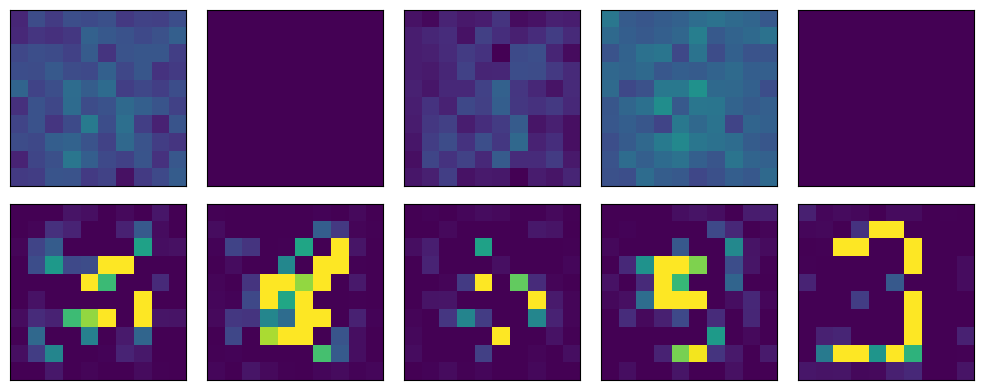

In [109]:
ns = 5
fig, ax = plt.subplots(2,ns, figsize=(10,4))

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

fig.subplots_adjust(hspace=0.1)

#### Testing the reconstruction with least squares

##### Gradient tests

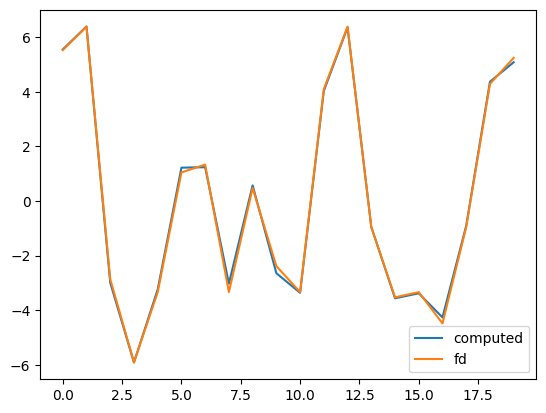

In [110]:
# test J(z) = 0.5 ||G(z)||_2^2
k=10

def test(z):
  k = len(z)//2
  zc  = z[:k] + 1j*z[k:]
  x   = decoderfunc_1D(zc, decoder)
 
  val = 0.5*np.linalg.norm(x)**2 
  #gradc = jac_decoder_1D(zc, decoder,type="normal").T@np.conj(x) - jac_decoder_1D(zc, decoder,type="conj").T@x
  
  gradc = jac_decoder_1D(zc, decoder,type="conj").T@np.conj(x) + np.conj(jac_decoder_1D(zc, decoder,type="normal")).T@x

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))
 
z = np.random.randn(2*k)
h = 1e-5
 
val, grad = test(z)
grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (test(z+h*e)[0] - test(z-h*e)[0])/(2*h)
 
plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

norm difference 0.03119767424217805
grad [ -3.66447184  -5.41227178   7.27208091   9.79009783  -3.40040539
   6.28069233   7.01865989   6.6007414  -11.87378933   3.42383773
   0.5015395   -0.54259592  -8.84821325   2.18195716   4.16789918
  -7.15321453   1.39482403  -5.53081543   4.82272158  -4.51313254]


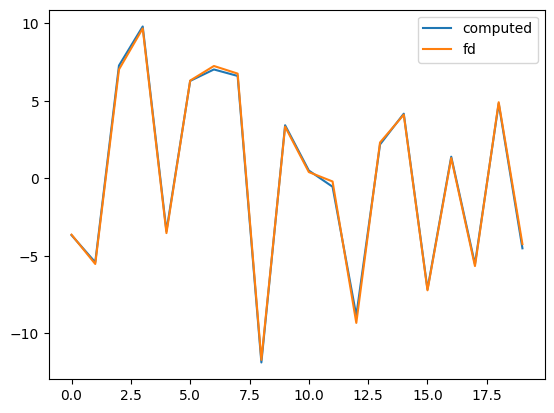

In [41]:
# gradient test for || G(z) - x ||_2^2 
h = 1e-5

#np.random.seed(1)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

k  = G.shape[1]


# ||G(z) - x ||_2^2
def bias_obj(z, x_obs): 
  k = len(z)//2
  n = len(x_obs)//2
  zc  = z[:k] + 1j*z[k:]
  xc_obs = x_obs[:n] + 1j*x_obs[n:]

  xc   = decoderfunc_1D(zc, decoder) # G(z)
 
  val = 0.5*np.linalg.norm(xc - xc_obs)**2 
  #gradc = jac_decoder_1D(zc, decoder,type="normal").T@np.conj(x) - jac_decoder_1D(zc, decoder,type="conj").T@x
  
  gradc = jac_decoder_1D(zc, decoder,type="conj").T@np.conj(xc - xc_obs) + np.conj(jac_decoder_1D(zc, decoder,type="normal")).T@(xc - xc_obs)

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))

zt = np.random.randn(2*k)
xt = np.random.randn(2*(I.shape[0])) 


val, grad = bias_obj(zt, xt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (bias_obj(zt+h*e, xt)[0] - bias_obj(zt-h*e, xt)[0])/(2*h)


print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

n 40000
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400)
x (400,)
y (40000,)
DA.T (400, 40000)
DG (400, 40)
DG_star.T (40, 400

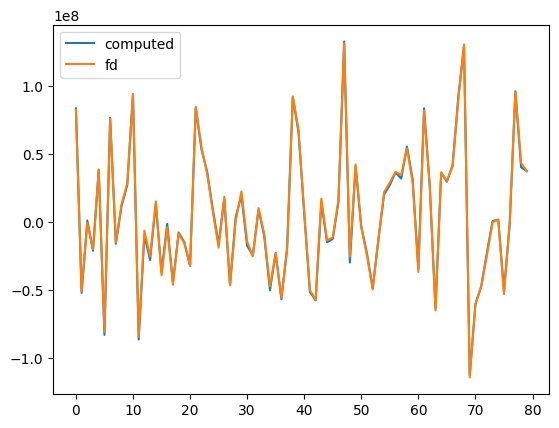

In [75]:
# gradient test for || A(G(z)) - y ||_2^2 custom defined
h = 1e-5

np.random.seed(1)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

def test(z, yobs):
  k = len(z)//2
  zc  = z[:k] + 1j*z[k:]
  x   = decoderfunc_1D(zc, decoder)
  y   = A.eval(x)

  print("x", x.shape)
  print("y", y.shape)

  DA = A.jac(x)
  DG = jac_decoder_1D(zc, decoder,type="normal")
  DG_star = jac_decoder_1D(zc, decoder,type="conj")

  print("DA.T", DA.T.shape)
  print("DG", DG.shape)
  print("DG_star.T", DG_star.T.shape)

 
  val = 0.5*np.linalg.norm(y - yobs)**2 
  
  gradc = 2*(DG_star).T@(DA.T@(y - yobs)) + 2*np.conj(DG).T@(DA.H@(y - yobs))

  return val, np.concatenate((np.real(gradc), np.imag(gradc)))

N = A.shape[0]
print("n", N)
z = np.random.randn(2*k)
yobs = np.random.randn(N)
val, grad = test(z, yobs)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (test(z+h*e, yobs)[0] - test(z-h*e, yobs)[0])/(2*h)

print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

norm difference 0.032459455311362184
grad [ 8.10068168 -3.43634959 -4.0927215  -2.2775814   3.6964783  -6.63793346
  2.11810012 -5.13249724  1.73090807  0.30909595  1.67076848 -7.789308
  1.50255659 -0.56701974  1.73324395 -4.45520914 -0.22015373 -2.88482496
  2.89194158  0.32566422]


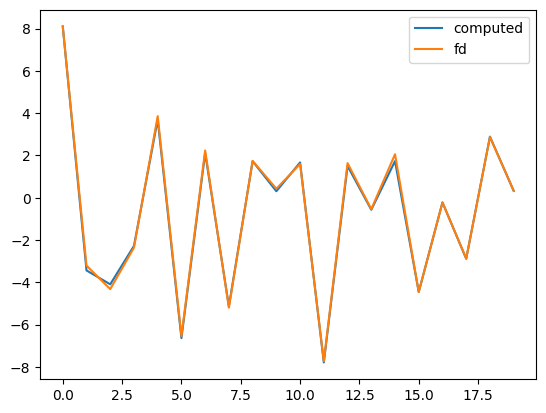

In [42]:
# gradient test for || A(G(z)) - y ||_2^2 from objective
h = 1e-5

np.random.seed(1)
#k  = G.shape[1]
#zt = np.random.randn(2*k)
#yt = np.random.randn(I.shape[0])

k  = G.shape[1]
zt = np.random.randn(2*k)
yt = np.random.randn(I.shape[0])

obj = lambda z : objective(z, yt, I, G, Gstar)

val, grad = obj(zt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)


print("norm difference", np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))
print("grad", grad)

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

In [124]:
print(np.exp(np.pi*1j))
print(cmath.exp(np.pi*1j))
print(i)

(-1+1.2246467991473532e-16j)
(-1+1.2246467991473532e-16j)
3


##### Individual reconstruction tests

Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 59
Jacobian evals: 59
Final gradient norm: 1.9450606819820773e-06
Reconstruction error (sigma = 1e-06):  0.07523235188155292


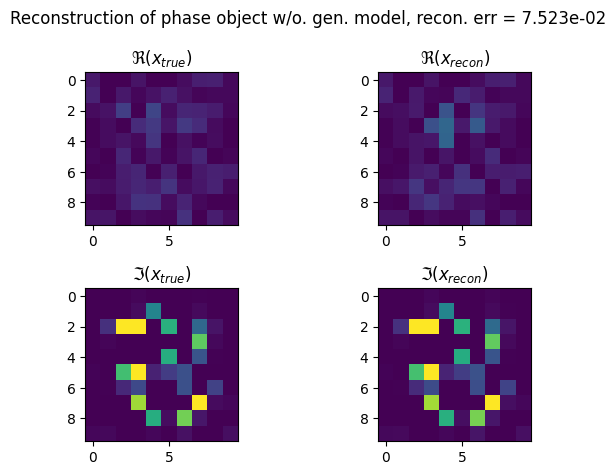

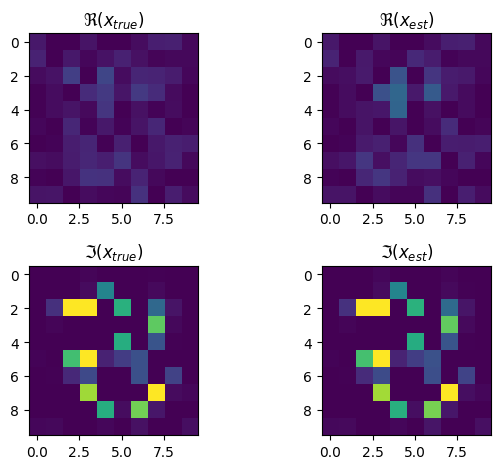

In [111]:
## tests of reconstruct with and without generative model
sigma = 1e-6

#xtrue = dataset[np.random.randint(0,dataset.shape[0])]

#x_random = np.random.normal(size=(1,sample_shape)) + 1j*np.random.normal(size=(1,sample_shape))
#x_tensor = make_tensor(x_random)
#x_random_recon_tf = decoder(encoder(x_tensor)) 
#x_random_recon = x_random_recon_tf.numpy().flatten()
#xtrue_1D = x_random_recon

#xdatatest = datatest[np.random.randint(0,datatest.shape[0])]
#xtrue_1D = xdatatest.flatten()


xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
#print(xtrue.shape)
#print(np.min(np.real(xtrue)))
#xtrue = xtrue - np.min(np.real(xtrue))

#x_load = np.load('G(z)_ex8_goodex.npy')  #x_random_recon #xtrue.flatten()
#xtrue_1D = x_load - np.min((np.real(x_load)))
#x_imag = np.load('autoenc(x)_ex1.npy') 
#x_bad = np.load('G(z)_ex2.npy')

#xtrue_1D = np.zeros(n) + 1j*np.imag(x_bad)

#plot_result(np.abs(x_load), np.abs(x_bad))

xtrue_1D = xtrue.flatten() #x_random.flatten() # #G.eval(np.random.randn(k) + 1j*np.random.randn(k))
#xtrue_1D = np.ones(n) + 1j*np.imag(x_imag)
#xtrue_1D = np.random.randn(n) + 1j*np.random.normal(size=(n))

# phase object in original dim
# phases = np.random.uniform(0, 2*np.pi, sample_size)
# x_random = np.exp(1j*phases)
# x_tensor = make_tensor_shape(x_random)
# print(x_tensor.shape)
# x_random_recon_tf = untrained_decoder(untrained_encoder(x_tensor)) 
# x_random_recon = x_random_recon_tf.numpy().flatten()
# xtrue_1D = x_random_recon

# phase object in latent space
# phases = np.random.uniform(0, 2*np.pi, latent_dim)
# rng = np.random.default_rng(99)
# GM    = rng.normal(0,1/n,size=(n,k))
# Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
# while Gsing[-1] < 1e-4: # check for small singular values
#     GM  = np.random.normal(0,10/n,size=(n,k))
#     Gsing = np.linalg.svd(GM, full_matrices=False, compute_uv=False, hermitian=False)
# linear_G = lambda z: GM@z 
# phases_long = linear_G(phases)

# xtrue_1D = np.exp(1j*phases_long)

# print(np.mean(phases_long))
# print(np.mean(np.abs(xtrue_1D)))

error, xhat_corr, yobs, result = reconstruct(xtrue_1D, A, I, Istar, w=1, sigma = sigma, lmbda = sigma)
#xhat_corr = xhat_corr.reshape((nx,nx))

#zhat_ex = result.x[:k] + 1j*result.x[k:]

print(f"Reconstruction error (sigma = {sigma}): ", error)

fig, ax = plt.subplots(2,2)

ax[0,0].imshow(np.real(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[0,0].set_title(r'$\Re(x_{true})$')
ax[1,0].imshow(np.imag(xtrue_1D.reshape((nx,nx))),clim=[0,1])
ax[1,0].set_title(r'$\Im(x_{true})$')
ax[0,1].imshow(np.real(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[0,1].set_title(r'$\Re(x_{recon})$')
ax[1,1].imshow(np.imag(xhat_corr.reshape((nx,nx))),clim=[0,1])
ax[1,1].set_title(r'$\Im(x_{recon})$')

fig.suptitle(rf"Reconstruction of phase object w/o. gen. model, recon. err = {error:.3e}")
fig.tight_layout()

plot_result(xtrue_1D, xhat_corr)

# compare with direct reconstruction of the test image
# compare_y = encoder(make_tensor_shape(xtrue))
# compare_x = decoder(compare_y).numpy()

# fig, ax = plt.subplots(2,1)

# ax[0].imshow(np.real(compare_x.reshape((nx,nx))),clim=[0,1])
# ax[0].set_title(r'$\Re(x_{recon})$')
# ax[1].imshow(np.imag(compare_x.reshape((nx,nx))),clim=[0,1])
# ax[1].set_title(r'$\Im(x_{recon})$')

# fig.tight_layout()
# plt.show()

In [ ]:
# split error
error_real = np.linalg.norm(np.real(xhat_corr) - np.real(xtrue_1D))/np.linalg.norm(np.real(xtrue_1D))
error_imag = np.linalg.norm(np.imag(xhat_corr) - np.imag(xtrue_1D))/np.linalg.norm(np.imag(xtrue_1D))

print(f"error real part: {error_real}")
print(f"error img part: {error_imag}")

print("norm xtrue: ", np.linalg.norm(xtrue_1D))

np.save('G(z)_ex9_randomex.npy', xtrue_1D)
np.save('G(z)_ex9_randomex_recon.npy', xhat_corr)

error real part: 3.469102310308395e-08
error img part: 4.418029281545693e-08
norm xtrue:  13.937400903513552


### Experiments

##### In- and out-distribution

In [95]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

x_export = np.zeros((len(sigmas), ns, n), dtype='complex')
#x_import = np.load('indistribution_ex.npy')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        print("j:", j)
        xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #here xtrue comes from the generative model
        #xtrue = np.ones(n) + 1j*np.imag(x_imag)
        #xtrue = x_random + np.min(np.real(x_random))

        x_export[i,j,:] = xtrue # allows you to compare outliers later as well
        #xtrue = x_import[i,j,:]

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        #errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        #errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
j: 0
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 61
Jacobian evals: 61
Final gradient norm: 1.5971011973901867e-06
j: 1
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 61
Jacobian evals: 61
Final gradient norm: 2.6572419845027344e-06
j: 2
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 58
Jacobian evals: 58
Final gradient norm: 2.1548928404711402e-06
j: 3
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 58
Jacobian evals: 58
Final gradient norm: 1.6798940364270939e-06
j: 4
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 68
Jacobian evals: 68
Final gradient norm: 2.8866808724143053e-06
j: 5
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 65
Jacobian evals: 65
Final gradient norm: 4.18450717

In [167]:
np.save('random_ex.npy', x_export)

In [45]:
# temporary save 
errors_i_in = np.copy(errors_i)
xhats_i_in  = np.copy(xhats_i)

errors_g_in = np.copy(errors_g)
xhats_g_in  = np.copy(xhats_g)

errors_c_in = np.copy(errors_c)
xhats_c_in  = np.copy(xhats_c)

In [46]:
for i in range(len(sigmas)):
    print(f"For noise level {sigmas[i]:.8e}  |  Mean error {np.mean(errors_i[i, :]):.6e}")


For noise level 1.00000000e-06  |  Mean error 1.362430e-01
For noise level 2.15443469e-05  |  Mean error 1.331019e-01
For noise level 4.64158883e-04  |  Mean error 1.236873e-01
For noise level 1.00000000e-02  |  Mean error 1.581800e-01
For noise level 2.15443469e-01  |  Mean error 1.392025e-01
For noise level 4.64158883e+00  |  Mean error 1.937654e-01
For noise level 1.00000000e+02  |  Mean error 6.466761e-01
For noise level 2.15443469e+03  |  Mean error 1.233730e+00
For noise level 4.64158883e+04  |  Mean error 1.738279e+00
For noise level 1.00000000e+06  |  Mean error 1.733459e+00


In [ ]:
print(f"noise: {sigmas[2]:.8e}")
print(errors_i[2,3])

print()

noise: 4.64158883e-04
0.0783090325708439


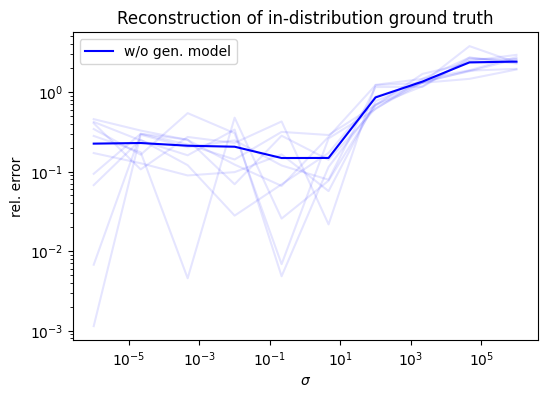

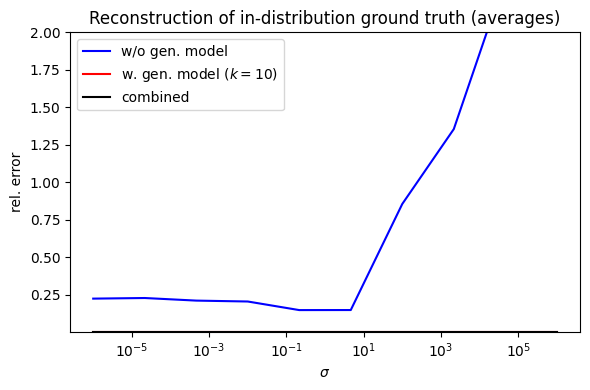

In [96]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

# ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
# ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

# ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
# ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth')
ax.legend()
#plt.savefig('MNIST_100_decoder_indistribution_lines.png', dpi=300)
plt.show()


# only averages
fig, ax = plt.subplots(1, figsize = (6,4))

ax.plot(sigmas, np.mean(errors_i, axis=1), 'b', label='w/o gen. model')
ax.plot(sigmas, np.mean(errors_g, axis=1), 'r', label='w. gen. model ($k=$%d)' % k)
ax.plot(sigmas, np.mean(errors_c, axis=1), 'k', label='combined')

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('Reconstruction of in-distribution ground truth (averages)')

ax.set_xscale('log') 
ax.set_ylim([0.001, 2])

# Optional: tighten x range to only include data
#ax.set_xlim([min(sigmas), max(sigmas)])

ax.legend()
plt.tight_layout()
#plt.savefig('MNIST_100_decoder_indistribution_averages.png', dpi=300)
plt.show()



In [48]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    print("i:", i)
    for j in range(ns):
        #print("j:", j)
        xdatatest = datatest[np.random.randint(0,datatest.shape[0])]
        xtrue = xdatatest.flatten()

        # phase object
        # phases = np.random.uniform(0, 2*np.pi, sample_shape)
        # xtrue = np.exp(1j*phases)
        
        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, Istar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, Gstar, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, Hstar, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

i: 0
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 90
Jacobian evals: 90
Final gradient norm: 2.785749225623634e-05
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 87
Jacobian evals: 87
Final gradient norm: 211.373302296815
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 430
Jacobian evals: 430
Final gradient norm: 0.7161467990855439
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 80
Jacobian evals: 80
Final gradient norm: 8.637040260958327e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 98
Jacobian evals: 98
Final gradient norm: 1369.5503450564809
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 286
Jacobian evals: 286
Final gradient norm: 1.6275632884820943
Result message: CONVERGENCE: REL_

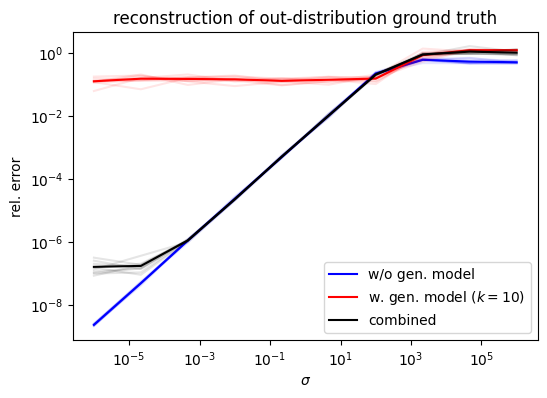

In [49]:
fig, ax = plt.subplots(1, figsize = (6,4))

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

# for scatter plot version

# for i in range(errors_i.shape[1]):
#     ax.scatter(sigmas, errors_i[:, i], color='b', alpha=1/ns, s=10)

# for i in range(errors_g.shape[1]):
#     ax.scatter(sigmas, errors_g[:, i], color='r', alpha=1/ns, s=10)

# for i in range(errors_c.shape[1]):
#     ax.scatter(sigmas, errors_c[:, i], color='k', alpha=1/ns, s=10)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of out-distribution ground truth')

ax.legend()
#plt.savefig('MNIST_100_decoder_outdistribution.png', dpi=300)

##### Bias

In [43]:
## bias experiments
# different samples for computing bias as the z0-term for in and out-distribution
ns     = 10

errors_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = datatest[np.random.randint(0,datatest.shape[0])].flatten()

    errors_in[j], xhats_in[j,:], y_obs_in, _ = reconstruct(x_in, I, G, Gstar, w=1, sigma=0, lmbda=0)
    errors_out[j], xhats_out[j,:],y_obs_out, _ = reconstruct(x_out, I, G, Gstar, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in):.6e}  |  Std dev {np.std(errors_in):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out):.6e}  |  Std dev {np.std(errors_out):.6e}")

Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 46
Jacobian evals: 46
Final gradient norm: 1.25535744926588e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 35
Jacobian evals: 35
Final gradient norm: 0.0005703479138028548
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 41
Jacobian evals: 41
Final gradient norm: 1.5158968308818027e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 32
Jacobian evals: 32
Final gradient norm: 0.000338325447354441
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 54
Jacobian evals: 54
Final gradient norm: 1.0263406000831356e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 28
Jacobian evals: 28
Final gradient norm: 0.00013114362108621966
Result message: CONVERGENCE

In [114]:
## bias experiments
# different samples for computing bias as the z0-term for in-distribution and varying its misspecification
ns     = 10
etas = np.logspace(-6,6,10)

bias_in = np.zeros((len(etas),ns))
xhats_in  = np.zeros((len(etas),ns, n),dtype='complex')

for i in range(len(etas)):
    for j in range(ns):
        x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
        art = i*(np.random.randn(n)+1j*np.random.randn(n))

        x_pert = x_in + art

        bias_in[i,j], xhats_in[i,j,:], y_obs_in, _ = reconstruct(x_pert, I, G, Gstar, w=1, sigma=0, lmbda=0)

print(f"%Mean bias in-distr {np.mean(errors_in):.6e}  |  Std dev {np.std(errors_in):.6e}")
print(f"%Mean bias out-distr {np.mean(errors_out):.6e}  |  Std dev {np.std(errors_out):.6e}")

Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 47
Jacobian evals: 47
Final gradient norm: 1.0786211874357805e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 39
Jacobian evals: 39
Final gradient norm: 1.5632276257841779e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 49
Jacobian evals: 49
Final gradient norm: 1.2193656981537316e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 63
Jacobian evals: 63
Final gradient norm: 1.962590024608642e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 44
Jacobian evals: 44
Final gradient norm: 1.2816899158436837e-06
Result message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Result status: 0
Function evals: 59
Jacobian evals: 59
Final gradient norm: 1.531501578588087e-06
Result message: CONVERGE

KeyboardInterrupt: 

In [ ]:
# different samples for computing bias as the zhat-term for in and out-distribution of the H-term -> TODO for different noise
ns     = 10

errors_in = np.zeros(ns)
bias_in = np.zeros(ns)
xhats_in  = np.zeros((ns, n),dtype='complex')

errors_out = np.zeros(ns)
bias_out = np.zeros(ns)
xhats_out  = np.zeros((ns, n),dtype='complex')


for j in range(ns):
    x_in = G.eval(np.random.randn(k) + 1j*np.random.randn(k))
    x_out = datatest[np.random.randint(0,datatest.shape[0])].numpy().flatten()

    errors_in[j], xhats_in[j,:], _, result_in = reconstruct(x_in, I, H, Hstar, w=1, sigma=0, lmbda=1)
    errors_out[j], xhats_out[j,:], _, result_out = reconstruct(x_out, I, H, Hstar, w=1, sigma=0, lmbda=1)

    x1x2_in = result_in.x[:k+n] + 1j*result_in.x[k+n:]
    x2_in = x1x2_in[k:]
    G_z_temp = xhats_in[j,:] - x2_in
    phi = np.mean(np.angle(x_in/G_z_temp)) # angle correction now has to happen outside of the reconstruct function
    G_z_in = np.exp(1j*phi)*G_z_temp
    bias_in[j] = np.linalg.norm(G_z_in - x_in)/np.linalg.norm(x_in)

    x1x2_out = result_out.x[:k+n] + 1j*result_out.x[k+n:]
    x2_out = x1x2_out[k:]
    G_z_temp = xhats_out[j,:] - x2_out
    phi = np.mean(np.angle(x_out/G_z_temp)) 
    G_z_out = np.exp(1j*phi)*G_z_temp
    bias_out[j] = np.linalg.norm(G_z_out - x_out)/np.linalg.norm(x_out)

print(f"%Mean bias in-distr {np.mean(bias_in):.6e}  |  Std dev {np.std(bias_in):.6e}")
print(f"%Mean bias out-distr {np.mean(bias_out):.6e}  |  Std dev {np.std(bias_out):.6e}")

%Mean bias out-distr 9.298423e-01  |  Std dev 5.190562e-02
%Mean bias out-distr 5.438300e-01  |  Std dev 2.704658e-02


#### Lipschitz estimates

In [ ]:
# for G
perturb_range = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
lip_const_G = []

for l in range(-10,10,1):
    z_lip = np.ones(k) + 1j*np.ones(k)
    z_lip = l*z_lip
    for i in range(100):
        for j in perturb_range:
            perturb = np.random.normal(0,j,k) + 1j*np.random.normal(0,j,k)
            z_pert = np.linalg.norm(perturb)
            G_pert = np.linalg.norm(G.eval(z_lip) - G.eval(z_lip+perturb))
            Lip = G_pert/z_pert
            lip_const_G.append(Lip)

print(np.max(lip_const_G))

8.474572630106548


In [50]:
perturb_range = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
lip_const_A = []

for l in range(-10,10,1):
    x_lip = np.ones(n) + 1j*np.ones(n)
    x_lip = l*x_lip
    for i in range(100):
        for j in perturb_range:
            perturb = np.random.normal(0,j,n)
            x_pert = np.linalg.norm(perturb)
            A_pert = np.linalg.norm(A.eval(x_lip) - A.eval(x_lip+perturb))
            Lip = A_pert/x_pert
            lip_const_A.append(Lip)

print(np.max(lip_const_A))
print(len(lip_const_A))

19459.973951883374
14000


In [51]:
perturb_range = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]
lip_const_AG = []

for l in range(-10,10,1):
    z_lip = np.ones(k) + 1j*np.ones(k)
    z_lip = l*z_lip
    for i in range(100):
        for j in perturb_range:
            perturb = np.random.normal(0,j,k)
            z_pert = np.linalg.norm(perturb)
            A_pert = np.linalg.norm(A.eval(G.eval(z_lip)) - A.eval(G.eval(z_lip+perturb)))
            Lip = A_pert/x_pert
            lip_const_AG.append(Lip)

print(np.max(lip_const_AG))

8246672609.24079


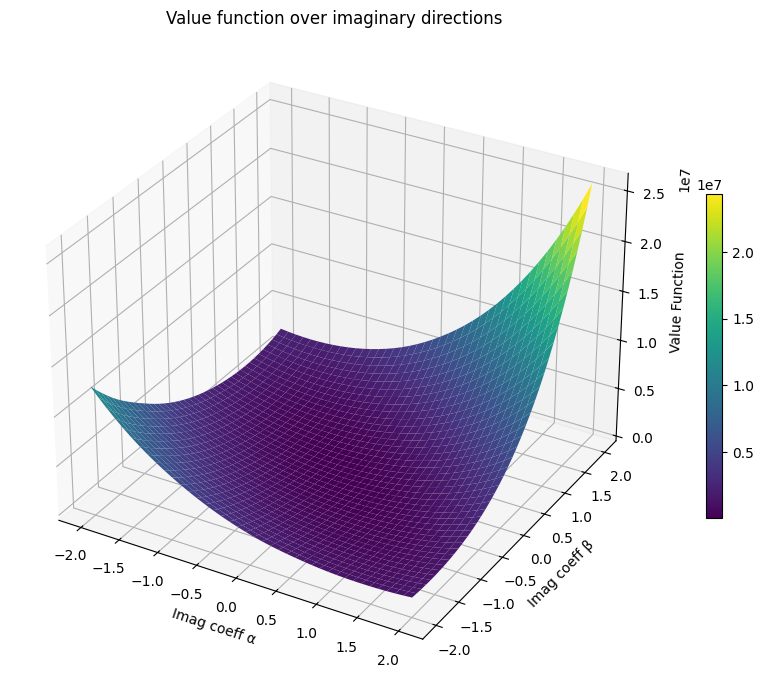

In [194]:
# Parameters
eps = 2.0        # Grid range
res = 40         # Grid resolution

# Define grid in (alpha, beta)
alpha = np.linspace(-eps, eps, res)
beta = np.linspace(-eps, eps, res)
A_grid, B_grid = np.meshgrid(alpha, beta)

# Preallocate value grid
V_grid = np.zeros_like(A_grid)

# Base latent vector (shape = (10,))
zc_init = zhat_ex
zc_base = np.copy(zc_init)  # <-- user-defined complex vector (ℂ^10)

# Choose 2 imaginary directions (user-defined or canonical)
v1 = np.random.randn(10) + 1j * np.random.randn(10)
v2 = np.random.randn(10) + 1j * np.random.randn(10)

# Normalize purely imaginary parts
v1 = 1j * np.imag(v1 / np.linalg.norm(np.imag(v1)))
v2 = 1j * np.imag(v2 / np.linalg.norm(np.imag(v2)))

yobs  = A.eval(xtrue_1D)
lmbda = 0

# Sweep grid and compute val(zc)
for i in range(res):
    for j in range(res):
        zc = zc_base + A_grid[i, j] * v1 + B_grid[i, j] * v2

        xc = G.eval(zc)
        Dx = G.jac(zc)
        Dxstar = Gstar.jac(zc)

        yp = A.eval(xc)
        Dy = A.jac(xc)

        DF = Dxstar.T @ Dy.T + Dx.H @ Dy.H
        res_y = yp - yobs

        val = 0.5 * np.linalg.norm(res_y)**2 + 0.5 * (lmbda**2) * np.linalg.norm(w * zc)**2
        V_grid[i, j] = val.real  # real-valued output

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A_grid, B_grid, V_grid, cmap='viridis')
ax.set_xlabel('Imag coeff α')
ax.set_ylabel('Imag coeff β')
ax.set_zlabel('Value Function')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.title("Value function over imaginary directions")
plt.tight_layout()
plt.show()


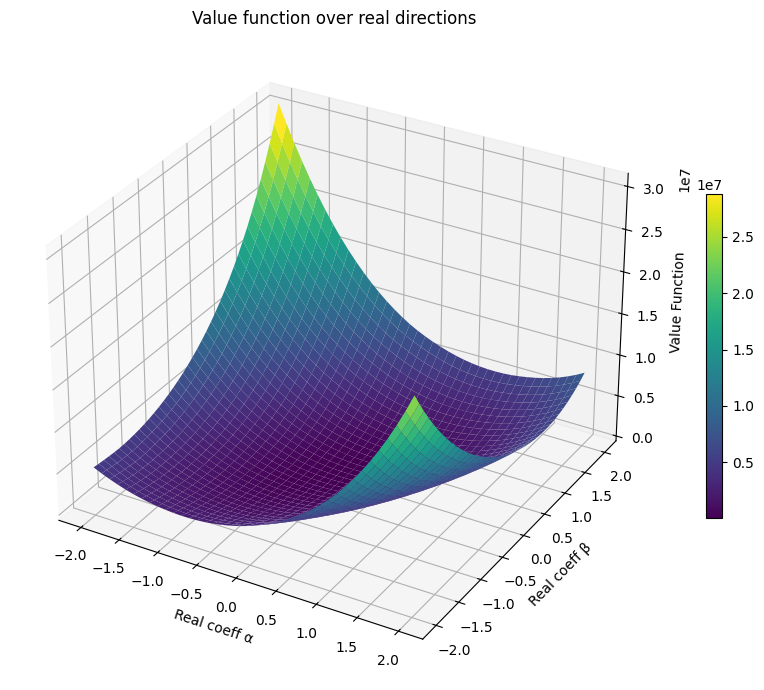

In [ ]:
# Parameters
eps = 2.0        # Grid range
res = 40         # Grid resolution

# Define grid in (alpha, beta)
alpha = np.linspace(-eps, eps, res)
beta = np.linspace(-eps, eps, res)
A_grid, B_grid = np.meshgrid(alpha, beta)

# Preallocate value grid
V_grid = np.zeros_like(A_grid)

# Base latent vector (shape = (10,))
zc_init = zhat_ex
zc_base = np.copy(zc_init)  # <-- user-defined complex vector (ℂ^10)

# Choose 2 real directions (user-defined or canonical)
v1 = np.random.randn(10) + 1j * np.random.randn(10)
v2 = np.random.randn(10) + 1j * np.random.randn(10)

# Normalize purely real parts
v1 = np.real(v1 / np.linalg.norm(np.real(v1)))
v2 = np.real(v2 / np.linalg.norm(np.real(v2)))

# Promote to complex
v1 = v1 + 0j
v2 = v2 + 0j

yobs  = A.eval(xtrue_1D)
lmbda = 0

# Sweep grid and compute val(zc)
for i in range(res):
    for j in range(res):
        zc = zc_base + A_grid[i, j] * v1 + B_grid[i, j] * v2

        xc = G.eval(zc)
        Dx = G.jac(zc)
        Dxstar = Gstar.jac(zc)

        yp = A.eval(xc)
        Dy = A.jac(xc)

        DF = Dxstar.T @ Dy.T + Dx.H @ Dy.H
        res_y = yp - yobs

        val = 0.5 * np.linalg.norm(res_y)**2 + 0.5 * (lmbda**2) * np.linalg.norm(w * zc)**2
        V_grid[i, j] = val.real  # real-valued output

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(A_grid, B_grid, V_grid, cmap='viridis')
ax.set_xlabel('Real coeff α')
ax.set_ylabel('Real coeff β')
ax.set_zlabel('Value Function')
fig.colorbar(surf, ax=ax, shrink=0.5)
plt.title("Value function over real directions")
plt.tight_layout()
plt.show()
